In [32]:
import pandas as pd
import numpy as np

blinks = pd.read_csv("sample-data/blinks.csv")
fixations = pd.read_csv("sample-data/fixations.csv")
saccades = pd.read_csv("sample-data/saccades.csv")

# test to see its working
print(blinks.head())

   blink id  start timestamp [ns]   end timestamp [ns]  duration [ms]
0         1   1747308624362212864  1747308624622460928     260.248064
1         2   1747308627605311744  1747308627795434752     190.123008
2         3   1747308650396380928  1747308650681753856     285.372928
3         4   1747308654325099776  1747308654705485824     380.386048
4         5   1747308663894022912  1747308664114145792     220.122880


##### Blinks

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# inter-blink interval: time duration between two consecutive blinks; the length of time the eyelids are open between blinks
# sorting by timestamp (but maybe redundant)
blinks = blinks.sort_values(by='start timestamp [ns]')
blinks['IBI [ms]'] = blinks['start timestamp [ns]'].diff() / 1e6  # convert ns → ms just to keep consistent

# strip unnecessary values and make a standalone dataframe we can safely modify 
blink_features = blinks[['duration [ms]', 'IBI [ms]']].dropna().copy()
blink_features['event_type'] = 'blink'

# scale
scaler = StandardScaler()
blink_scaled = scaler.fit_transform(blink_features[['duration [ms]', 'IBI [ms]']])

# Gaussian Mixture Model (GMM) clustering
# random state is just my Blandford number lol
gmm = GaussianMixture(n_components=2, random_state=35)
blink_features['cluster'] = gmm.fit_predict(blink_scaled)

# check it works
print(blink_features['cluster'].value_counts())

cluster
1    10
0     4
Name: count, dtype: int64


##### Fixations

In [47]:
# including x and y here to later calculate spatial drift which could indicate fatigue/time
fixation_features = fixations[['duration [ms]', 'fixation x [px]', 'fixation y [px]']].dropna().copy()
fixation_features['event_type'] = 'fixation'

# scale
fixation_scaled = scaler.fit_transform(fixation_features[['duration [ms]', 'fixation x [px]', 'fixation y [px]']])

# clustering
gmm = GaussianMixture(n_components=2, random_state=35)
fixation_features['cluster'] = gmm.fit_predict(fixation_scaled)

# check it works
print(fixation_features['cluster'].value_counts())

cluster
0    241
1    123
Name: count, dtype: int64


calculating spatial drift to (hopefully) indicate fatigue from fixation coordinates

In [41]:
# Add timestamp ONLY for temporal drift calculation
fixation_temp = fixations[
    ['start timestamp [ns]', 'fixation x [px]', 'fixation y [px]']
].dropna().copy()

# Sort just in case the CSV is out of order
fixation_temp = fixation_temp.sort_values(by='start timestamp [ns]')

# Compute rolling dispersion over a window of 10 fixations
fixation_temp['x_dispersion'] = fixation_temp['fixation x [px]'].rolling(window=10).std()
fixation_temp['y_dispersion'] = fixation_temp['fixation y [px]'].rolling(window=10).std()

# Combine for total spatial drift (Euclidean std)
fixation_temp['spatial_drift'] = (
    fixation_temp['x_dispersion']**2 + fixation_temp['y_dispersion']**2
)**0.5

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


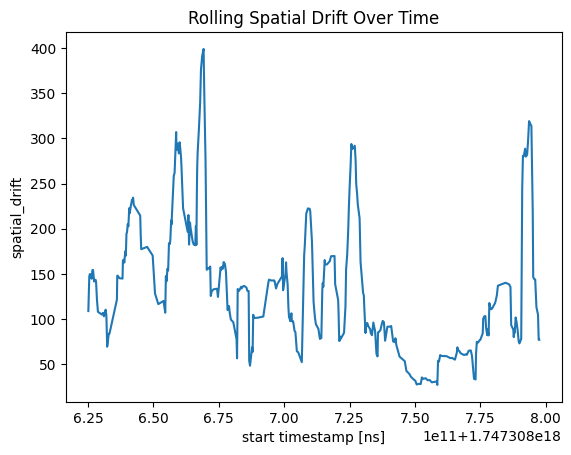

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=fixation_temp, x='start timestamp [ns]', y='spatial_drift')
plt.title("Rolling Spatial Drift Over Time")
plt.show()

##### Saccades

In [44]:
saccades_features = saccades[['duration [ms]', 'amplitude [px]', 'amplitude [deg]', 'mean velocity [px/s]', 'peak velocity [px/s]']].dropna().copy()
fixation_features['event_type'] = 'fixation'


# scale
fixation_scaled = scaler.fit_transform(fixation_features[['duration [ms]', 'fixation x [px]', 'fixation y [px]']])

# clustering
gmm = GaussianMixture(n_components=2, random_state=35)
fixation_features['cluster'] = gmm.fit_predict(fixation_scaled)